<a href="https://colab.research.google.com/github/solosolve-ai/solosolve-ai/blob/main/SoloSolve_Gemma3_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

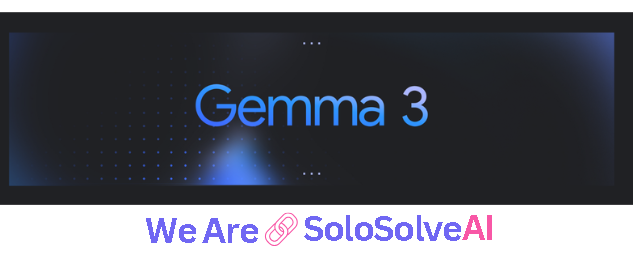

In [2]:
!pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3 -q --upgrade
!pip install datasets pandas accelerate peft trl -q
#!pip uninstall bitsandbytes -y
#!pip install --force-reinstall 'https://github.com/bitsandbytes-foundation/bitsandbytes/releases/download/continuous-release_multi-backend-refactor/bitsandbytes-0.44.1.dev0-py3-none-manylinux_2_24_x86_64.whl'

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 134.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.

In [3]:
import torch
from transformers import AutoTokenizer, Gemma3ForCausalLM, BitsAndBytesConfig
from huggingface_hub import notebook_login
from datasets import load_dataset
import pandas as pd
import json
import os
import warnings

warnings.filterwarnings('ignore')

In [4]:
notebook_login()

In [5]:
TEACHER_MODEL_ID = "google/gemma-3-4b-it" # Instruction-tuned model
RAW_DATASET_NAME = "McAuley-Lab/Amazon-Reviews-2023"
RAW_DATASET_CONFIG = "raw_review_All_Beauty" # Using a smaller subset for example
CURATED_COMPLAINTS_FILE = "amazon_fashion_complaints_sample.parquet"
SFT_OUTPUT_FILE = "sft_complaint_resolution_dataset.jsonl"
SEED = 42

COMPLAINT_CATEGORIES = [
    "Item Damaged/Defective",
    "Wrong Item Received/Not as Pictured",
    "Sizing Issue (Too Small/Large/Inconsistent)",
    "Quality Issue (Poor Construction/Material)",
    "Missing Parts/Item",
    "Shipping & Delivery Issue", # Added based on common complaints
    "Other"
]

# --- AMAZON POLICY SNIPPET ---
# IMPORTANT: Replace this with the full, relevant Amazon policy text.
# For brevity in this snippet, only a placeholder is included.
AMAZON_POLICY_TEXT = """
Return Window: Most items sold on Amazon.com can be returned within 30 days of delivery.
Non-Returnable Items: Perishables, products with health/safety risks once sold, customized products.
Refund Timeline: Most refunds are fully refunded in 3-5 days after we receive and process your return.
Replacements/Exchanges: Yes, most items are eligible.
Return Process: Go to Your Orders, select Return or Replace Items. Select reason. Choose return method. Print label.
Label-Free, Box-Free: Available for items sold and fulfilled by Amazon. QR code provided.
Damaged/Defective: We’ll ship you a replacement of the exact item. Or refund.
Third-Party Sellers: Returns sent to seller. Must offer US return address, prepaid label, or full refund without return. A-to-z Guarantee if no response.
Fees: Generally free. Late fees (20%) or damage fees (up to 50%, 100% for Luxury) may apply. Restocking fees for opened software/games (100%).
"""

MAX_SFT_EXAMPLES = 100 # Limit for this example run, increase for a full dataset
MIN_REVIEW_TEXT_LENGTH = 50 # Minimum characters for a review to be considered
BAD_RATING_THRESHOLD = 3 # Reviews with rating < threshold are considered potential complaints

In [6]:
# Load a portion of the dataset
try:
    dataset = load_dataset(RAW_DATASET_NAME, RAW_DATASET_CONFIG, split='full[:1%]', trust_remote_code=True) # Load 1% for faster example
except Exception as e:
    print(f"Failed to load full dataset slice, trying with a fixed small number of samples: {e}")
    dataset = load_dataset(RAW_DATASET_NAME, RAW_DATASET_CONFIG, split='full[:10000]', trust_remote_code=True)


df = dataset.to_pandas()
df_complaints = df[
    (df['rating'] < BAD_RATING_THRESHOLD) &
    (df['text'].str.len() >= MIN_REVIEW_TEXT_LENGTH)
].copy()

if not os.path.exists(CURATED_COMPLAINTS_FILE) or len(df_complaints) > 0 : # Save if new data processed
    df_complaints_sample = df_complaints.sample(min(len(df_complaints), MAX_SFT_EXAMPLES * 2), random_state=SEED) if len(df_complaints) > MAX_SFT_EXAMPLES * 2 else df_complaints
    df_complaints_sample.to_parquet(CURATED_COMPLAINTS_FILE)
    print(f"Saved {len(df_complaints_sample)} curated complaints to {CURATED_COMPLAINTS_FILE}")
else:
    print(f"Loading existing curated complaints from {CURATED_COMPLAINTS_FILE}")
    df_complaints_sample = pd.read_parquet(CURATED_COMPLAINTS_FILE)

print(f"Using {len(df_complaints_sample)} samples for SFT data generation.")

README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

All_Beauty.jsonl:   0%|          | 0.00/327M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Saved 200 curated complaints to amazon_fashion_complaints_sample.parquet
Using 200 samples for SFT data generation.


In [11]:
import torch
print(torch.cuda.is_available())  # Should return True
!nvidia-smi

True
Tue May 13 23:18:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             43W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+

In [18]:
### 6. Load "Teacher" Gemma 3 Model and Tokenizer

TEACHER_MODEL_ID = "google/gemma-3-4b-it"

print(f"Loading tokenizer for {TEACHER_MODEL_ID}...")
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
print("Tokenizer loaded successfully.")

print(f"Loading model {TEACHER_MODEL_ID} to CPU first...")
teacher_model = None # Initialize to None
try:
    # Load model weights directly to CPU
    teacher_model_cpu = Gemma3ForCausalLM.from_pretrained(
        TEACHER_MODEL_ID,
        torch_dtype=torch.bfloat16
        # No device_map here, loads to CPU by default
    )
    print("Model weights loaded to CPU.")

    # Check if GPU is available and move the model
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Moving model to GPU: {device}...")
        teacher_model = teacher_model_cpu.to(device)
        print("Teacher model successfully moved to GPU.")
        print(f"Teacher model device: {teacher_model.device}")
    else:
        print("CUDA (GPU) not available. Using model on CPU.")
        teacher_model = teacher_model_cpu # Keep on CPU if no GPU
        print(f"Teacher model device: {teacher_model.device}")

except Exception as e:
    print(f"Error during model loading or moving to GPU for {TEACHER_MODEL_ID}: {e}")
    # teacher_model remains None or partially loaded if error occurs

# Clean up the CPU copy if successfully moved to GPU to free CPU RAM,
# though with 83GB system RAM, this might not be strictly necessary immediately.
if 'teacher_model_cpu' in locals() and teacher_model is not None and teacher_model.device.type == 'cuda':
    del teacher_model_cpu
    torch.cuda.empty_cache() # Clear any cached memory on GPU
    print("Cleaned up CPU model copy and cleared GPU cache.")

Loading tokenizer for google/gemma-3-4b-it...
Tokenizer loaded successfully.
Loading model google/gemma-3-4b-it to CPU first...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model weights loaded to CPU.
Moving model to GPU: cuda...
Teacher model successfully moved to GPU.
Teacher model device: cuda:0
Cleaned up CPU model copy and cleared GPU cache.


In [19]:
MASTER_PROMPT_TEMPLATE = """
You are an expert Amazon Customer Service Resolution AI. Your task is to analyze a customer complaint and the relevant Amazon Return Policy to determine the appropriate resolution.
Based **strictly** on the provided Amazon Return Policy and the customer complaint, provide your analysis in the following JSON format.
Do NOT invent policy or make assumptions beyond what is stated.
If information is insufficient to make a definitive decision based *only* on the policy and complaint, state that clearly in the 'reasoning'.

**Amazon Return Policy Context:**
---
{amazon_policy_snippet}
---

**Customer Complaint:**
---
Review Title: {review_title}
Review Text: {review_text}
Star Rating: {review_rating}
Product ASIN: {product_asin}
---

**JSON Output Format:**
{{
  "is_actionable_complaint": <boolean>,
  "complaint_category": "{complaint_categories_options}",
  "complaint_summary": "<concise_summary_of_the_core_issue>",
  "key_entities": ["<list_of_keywords_or_phrases_from_complaint>"],
  "decision": "<Return_for_Refund/Return_for_Replacement/Partial_Refund/Full_Refund_No_Return/Product_Support_Advised/No_Action_Policy/No_Action_Insufficient_Info/No_Action_Not_A_Complaint>",
  "refund_percentage": <integer_0_to_100>,
  "return_instructions": "<step_by_step_amazon_return_instructions_if_applicable_or_NA_or_Refer_to_Product_Support>",
  "reasoning": "<detailed_explanation_of_the_decision_citing_specific_policy_clauses_or_lack_thereof_or_why_not_a_complaint>"
}}

**Example 1 (Damaged Item):**
Review Title: Arrived Broken
Review Text: The vase I ordered came in pieces. Completely shattered.
Star Rating: 1.0
Product ASIN: B00EXAMPLE1

Output JSON:
{{
  "is_actionable_complaint": true,
  "complaint_category": "Item Damaged/Defective",
  "complaint_summary": "Customer received a vase that was shattered upon arrival.",
  "key_entities": ["vase", "broken", "shattered", "pieces"],
  "decision": "Return_for_Replacement",
  "refund_percentage": 0,
  "return_instructions": "Go to Your Orders, select 'Return or replace items' beside the item. Select 'Item Damaged/Defective' as the reason. A replacement order will be created. You'll need to return the original item by the 'Return By Date' provided.",
  "reasoning": "The item arrived damaged, which is covered by Amazon's policy for defective items. Customer is eligible for a replacement."
}}

**Example 2 (Out of Policy - Change of Mind Late):**
Review Title: Don't want it anymore
Review Text: I bought this 2 months ago, never opened it. Decided I don't need it.
Star Rating: 3.0
Product ASIN: B00EXAMPLE2

Output JSON:
{{
  "is_actionable_complaint": true,
  "complaint_category": "Other",
  "complaint_summary": "Customer wants to return an unopened item purchased 2 months ago due to change of mind.",
  "key_entities": ["2 months ago", "never opened", "don't need it"],
  "decision": "No_Action_Policy",
  "refund_percentage": 0,
  "return_instructions": "NA",
  "reasoning": "The item was purchased 2 months ago. Amazon's standard return window is 30 days of delivery for most items. This return request is outside the policy window for a change of mind."
}}

**Current Complaint to Analyze:**
Review Title: {review_title}
Review Text: {review_text}
Star Rating: {review_rating}
Product ASIN: {product_asin}

Output JSON:
"""

In [20]:
def generate_sft_example(review_data, policy_text, model, tokenizer):
    prompt = MASTER_PROMPT_TEMPLATE.format(
        amazon_policy_snippet=policy_text,
        review_title=review_data.get('title', 'N/A'),
        review_text=review_data.get('text', ''),
        review_rating=review_data.get('rating', 'N/A'),
        product_asin=review_data.get('asin', 'N/A'),
        complaint_categories_options=" / ".join(COMPLAINT_CATEGORIES)
    )

    model_inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096).to(model.device) # Gemma 3 4B can handle longer, but be mindful of generation time

    input_len = model_inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        generation_output = model.generate(
            **model_inputs,
            max_new_tokens=1024, # Increased for detailed JSON
            do_sample=True, # Enable sampling for more diverse outputs if desired, but can reduce consistency
            temperature=0.3, # Lower temperature for more factual JSON
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(generation_output[0][input_len:], skip_special_tokens=True).strip()

    try:
        # Attempt to find the JSON block if the model adds extra text
        json_start = generated_text.find('{')
        json_end = generated_text.rfind('}') + 1
        if json_start != -1 and json_end != -1 and json_end > json_start:
            json_str = generated_text[json_start:json_end]
            parsed_json = json.loads(json_str)
            # Basic validation of top-level keys
            required_keys = {"is_actionable_complaint", "complaint_category", "decision", "refund_percentage", "reasoning"}
            if not required_keys.issubset(parsed_json.keys()):
                # print(f"Generated JSON missing required keys: {generated_text}")
                return None
            return {"prompt_used": prompt, "generated_json_payload": parsed_json}
        else:
            # print(f"Could not extract valid JSON from: {generated_text}")
            return None
    except json.JSONDecodeError:
        # print(f"JSONDecodeError for: {generated_text}")
        return None
    except Exception as e:
        # print(f"Other error parsing JSON ({e}): {generated_text}")
        return None

sft_examples = []
processed_count = 0
for index, row in df_complaints_sample.iterrows():
    if processed_count >= MAX_SFT_EXAMPLES:
        break
    # print(f"Processing review {index+1}/{len(df_complaints_sample)} (Target: {MAX_SFT_EXAMPLES})...")
    example_data = {
        'title': row.get('title'),
        'text': row.get('text'),
        'rating': row.get('rating'),
        'asin': row.get('asin')
    }
    generated_data = generate_sft_example(example_data, AMAZON_POLICY_TEXT, teacher_model, tokenizer)

    if generated_data:
        sft_examples.append(generated_data)
        processed_count += 1
        if processed_count % 10 == 0:
            print(f"Successfully generated {processed_count}/{MAX_SFT_EXAMPLES} SFT examples.")

print(f"\nTotal SFT examples generated and validated: {len(sft_examples)}")

with open(SFT_OUTPUT_FILE, 'w') as f:
    for example in sft_examples:
        # We need to decide on the final SFT format.
        # For SFTTrainer, often a single text field is used, or specific columns.
        # Example format: {"text": "### Instruction:\n{instruction}\n\n### Input:\n{input_context}\n\n### Response:\n{output_json}"}
        # For now, just saving the prompt and the generated payload.
        # The prompt_used already contains the policy and review.
        sft_record = {
            "instruction": "Analyze the customer complaint based on Amazon's return policy and provide a resolution in JSON format.",
            "input_context_and_complaint": example["prompt_used"].split("**JSON Output Format:**")[0] + "\nAnalyze the current complaint and provide the JSON output:", # Simplified input
            "output_json_str": json.dumps(example["generated_json_payload"])
        }
        # Alternative simpler format for SFTTrainer if it expects a single text field:
        # formatted_text = f"### Instruction:\nAnalyze the customer complaint based on Amazon's return policy and provide a resolution in JSON format.\n\n### Complaint & Policy:\n{example['prompt_used'].split('Output JSON:')[0]}\n\n### Response:\n{json.dumps(example['generated_json_payload'])}"
        # f.write(json.dumps({"text": formatted_text}) + "\n")
        f.write(json.dumps(sft_record) + "\n")


print(f"SFT dataset saved to {SFT_OUTPUT_FILE}")

Successfully generated 10/100 SFT examples.
Successfully generated 20/100 SFT examples.
Successfully generated 30/100 SFT examples.
Successfully generated 40/100 SFT examples.
Successfully generated 50/100 SFT examples.
Successfully generated 60/100 SFT examples.
Successfully generated 70/100 SFT examples.
Successfully generated 80/100 SFT examples.
Successfully generated 90/100 SFT examples.
Successfully generated 100/100 SFT examples.

Total SFT examples generated and validated: 100
SFT dataset saved to sft_complaint_resolution_dataset.jsonl


Successfully loaded 100 records from sft_complaint_resolution_dataset.jsonl

--- Initial DataFrame from SFT Payloads (100 records) ---
   is_actionable_complaint                                 complaint_category  \
0                     True         Quality Issue (Poor Construction/Material)   
1                     True  Item Damaged/Defective / Quality Issue (Poor C...   
2                     True  Quality Issue (Poor Construction/Material) / O...   
3                     True                             Item Damaged/Defective   
4                     True         Quality Issue (Poor Construction/Material)   

                                   complaint_summary  \
0  Customer states the product is not performing ...   
1  Customer reports a defect in the lash guide – ...   
2  Customer claims the product does not perform i...   
3  Customer reports a plastic piece is detaching ...   
4  Customer is dissatisfied with the bow's constr...   

                                        k

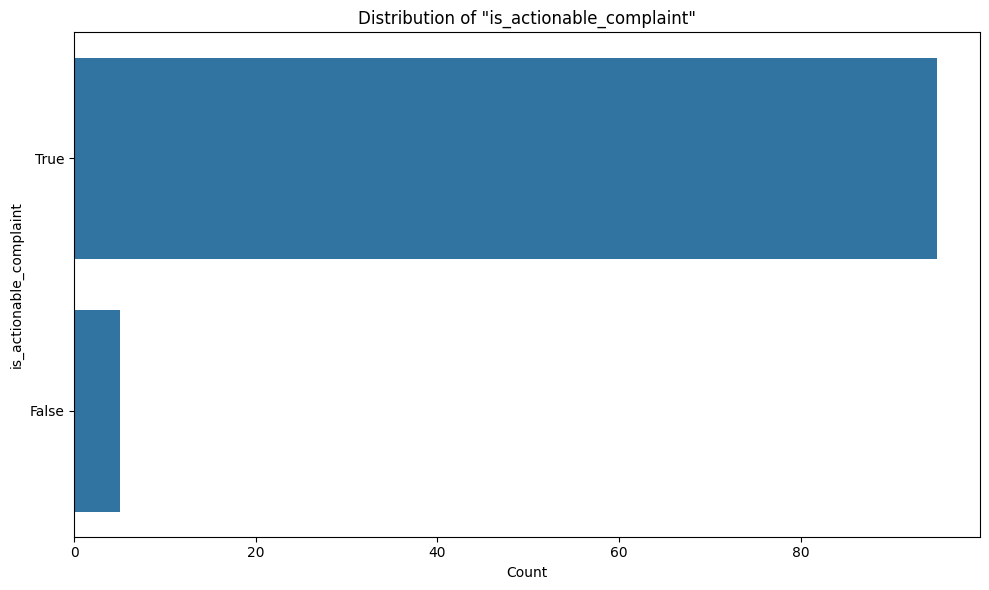


Value Counts for is_actionable_complaint:
is_actionable_complaint
True     95.0
False     5.0
Name: proportion, dtype: float64%



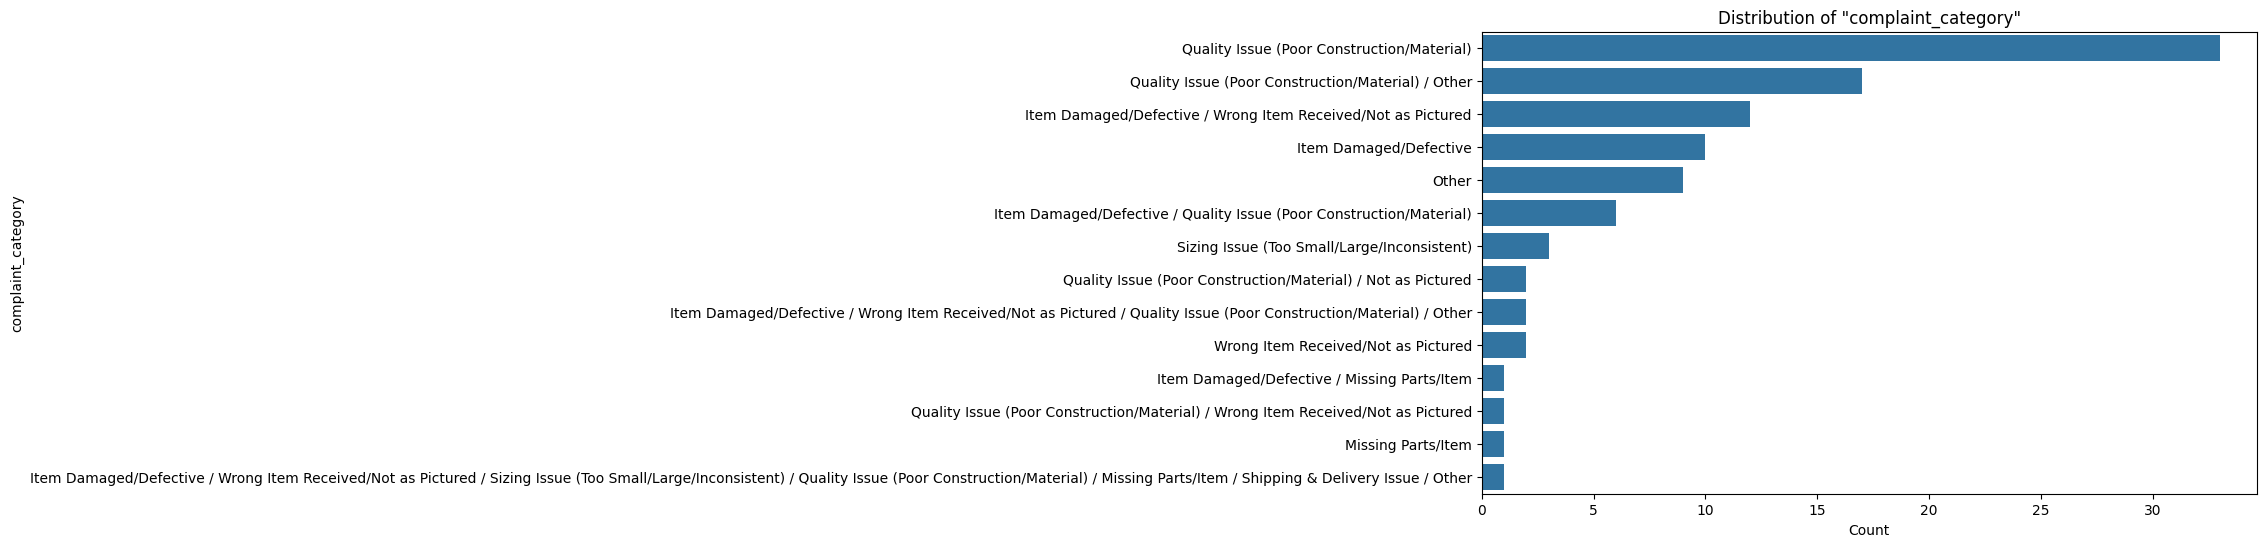


Value Counts for complaint_category:
complaint_category
Quality Issue (Poor Construction/Material)                                                                                                                                                                          33.0
Quality Issue (Poor Construction/Material) / Other                                                                                                                                                                  17.0
Item Damaged/Defective / Wrong Item Received/Not as Pictured                                                                                                                                                        12.0
Item Damaged/Defective                                                                                                                                                                                              10.0
Other                                                                      

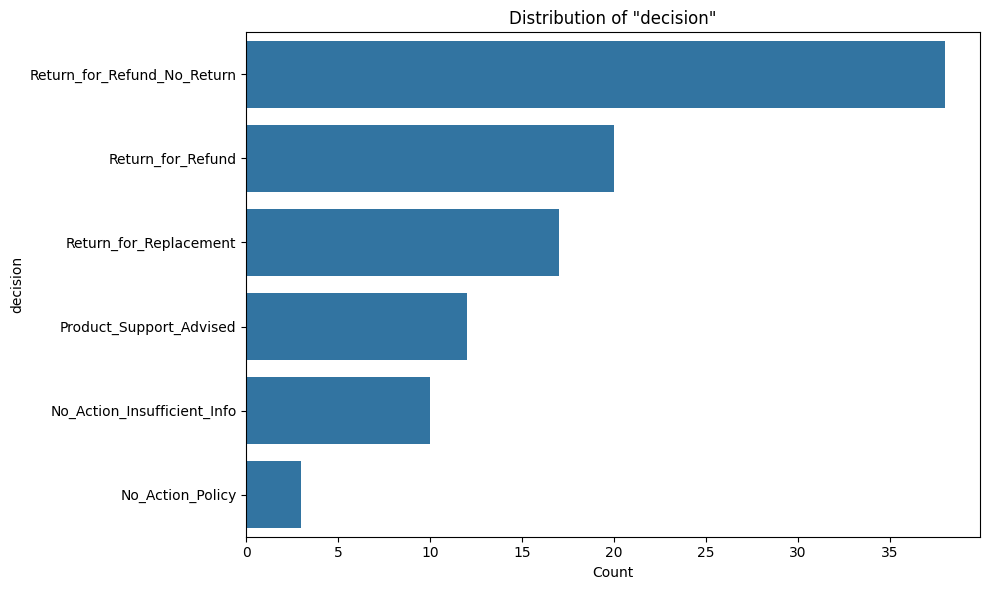


Value Counts for decision:
decision
Return_for_Refund_No_Return    38.0
Return_for_Refund              20.0
Return_for_Replacement         17.0
Product_Support_Advised        12.0
No_Action_Insufficient_Info    10.0
No_Action_Policy                3.0
Name: proportion, dtype: float64%



--- 4. Analysis of Numerical Fields ---


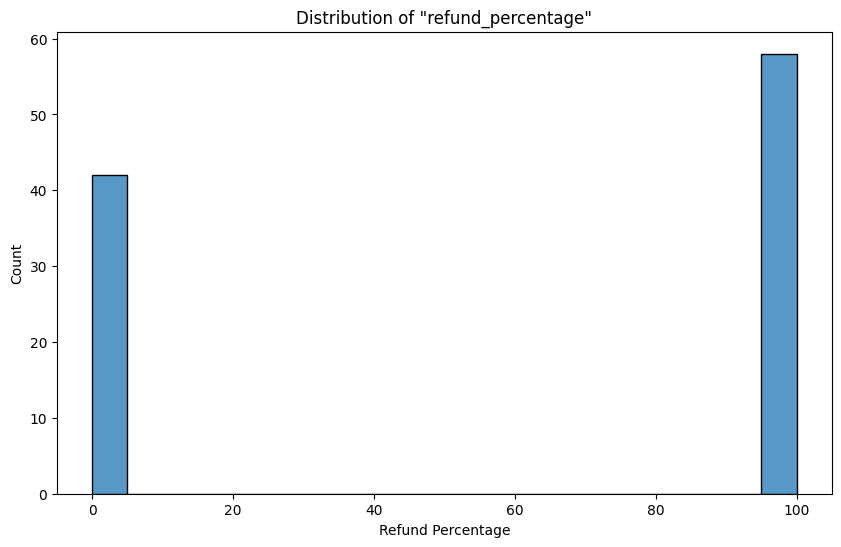


Descriptive Statistics for 'refund_percentage':
count    100.000000
mean      58.000000
std       49.604496
min        0.000000
25%        0.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: refund_percentage_numeric, dtype: float64


--- 5. Text Field Length Analysis ---


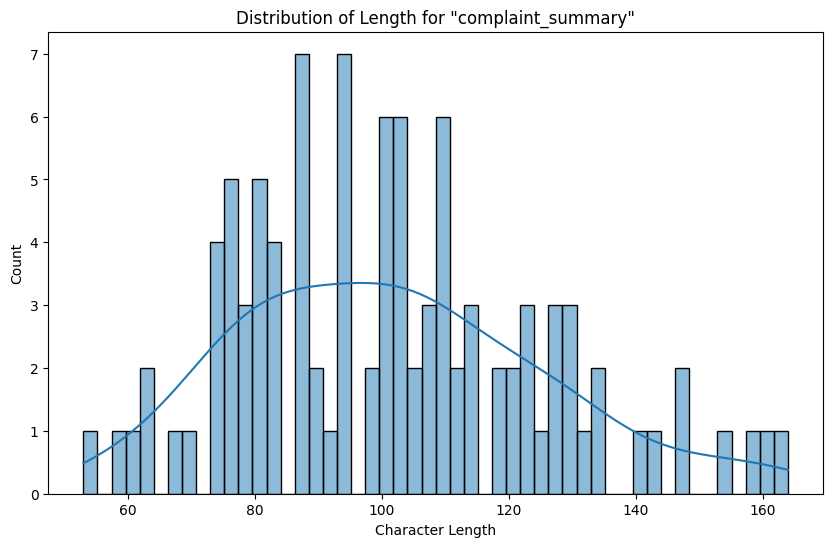


Descriptive Statistics for 'complaint_summary' length:
count    100.000000
mean     101.500000
std       24.168391
min       53.000000
25%       82.000000
50%      100.000000
75%      116.000000
max      164.000000
Name: complaint_summary_length, dtype: float64


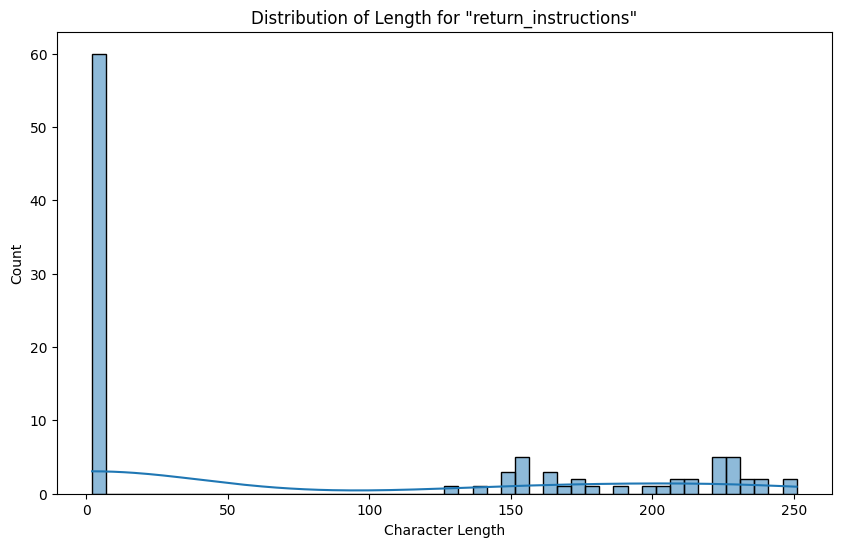


Descriptive Statistics for 'return_instructions' length:
count    100.000000
mean      79.420000
std       97.997236
min        2.000000
25%        2.000000
50%        2.000000
75%      175.250000
max      251.000000
Name: return_instructions_length, dtype: float64


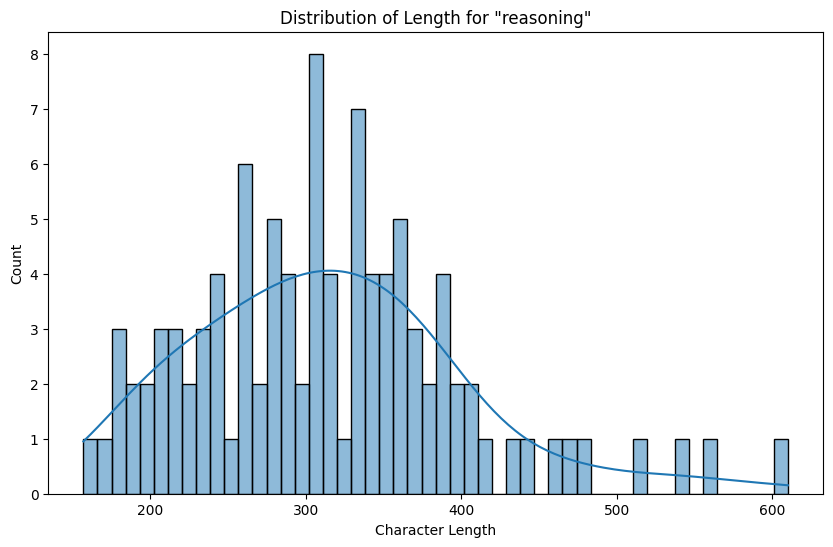


Descriptive Statistics for 'reasoning' length:
count    100.000000
mean     314.300000
std       87.142343
min      157.000000
25%      254.750000
50%      307.500000
75%      362.000000
max      610.000000
Name: reasoning_length, dtype: float64


--- 6. Keyword/Entity Analysis (Simple Example) ---
Top 20 Most Common Key Entities:
- hair: 5
- instructions: 5
- brush: 4
- useless: 4
- teeth: 3
- plastic: 3
- wig: 3
- thin: 3
- pressure: 2
- detaching: 2
- quality: 2
- bristles: 2
- flimsy: 2
- dull: 2
- conditioner: 2
- bottle: 2
- not working: 2
- scent: 2
- color: 2
- broke: 2


--- 7. Qualitative Spot-Checking (Manual Review Recommended) ---
It is highly recommended to manually review a sample of the generated SFT data.
Focus on:
  - **Policy Alignment:** Does the 'decision' and 'reasoning' strictly follow the provided Amazon policy?
  - **Reasoning Quality:** Is the 'reasoning' clear, logical, and does it cite policy where appropriate?
  - **Instruction Correctness:** Are 'return_i

In [21]:
### 9. Analyzing the SFT Output File (sft_complaint_resolution_dataset.jsonl)

import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

SFT_OUTPUT_FILE = "sft_complaint_resolution_dataset.jsonl" # Ensure this matches your output file

# --- 1. Load the Generated SFT Dataset ---
sft_data = []
try:
    with open(SFT_OUTPUT_FILE, 'r') as f:
        for line in f:
            try:
                sft_data.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Skipping malformed JSON line: {line.strip()}")
    print(f"Successfully loaded {len(sft_data)} records from {SFT_OUTPUT_FILE}")
except FileNotFoundError:
    print(f"Error: SFT output file not found at {SFT_OUTPUT_FILE}. Please ensure Phase 1 completed.")
    sft_data = [] # Ensure sft_data is defined even if file not found

if not sft_data:
    print("No SFT data to analyze. Exiting analysis.")
else:
    # Extract the generated JSON payloads for easier analysis
    generated_payloads = [record.get("output_json_str") for record in sft_data if "output_json_str" in record]
    parsed_payloads = []
    for i, payload_str in enumerate(generated_payloads):
        try:
            parsed_payloads.append(json.loads(payload_str))
        except json.JSONDecodeError:
            print(f"Could not parse JSON payload for record {i}: {payload_str[:200]}...") # Print snippet of bad JSON

    if not parsed_payloads:
        print("No valid JSON payloads found in the SFT data. Cannot perform detailed analysis.")
    else:
        df_sft = pd.DataFrame(parsed_payloads)
        print(f"\n--- Initial DataFrame from SFT Payloads ({len(df_sft)} records) ---")
        print(df_sft.head())
        print(f"\nDataFrame Info:")
        df_sft.info()

        # --- 2. Schema Adherence and Field Completeness ---
        print("\n\n--- 2. Schema Adherence & Field Completeness ---")
        expected_keys = {
            "is_actionable_complaint", "complaint_category", "complaint_summary",
            "key_entities", "decision", "refund_percentage",
            "return_instructions", "reasoning"
        }
        missing_keys_count = 0
        for i, payload in enumerate(parsed_payloads):
            if not expected_keys.issubset(payload.keys()):
                missing_keys_count += 1
                # print(f"Record {i} is missing one or more expected keys. Found: {list(payload.keys())}")
        if missing_keys_count > 0:
            print(f"WARNING: {missing_keys_count}/{len(parsed_payloads)} records are missing one or more expected top-level keys.")
        else:
            print("All records adhere to the basic top-level key schema.")

        # --- 3. Distribution Analysis of Key Categorical Fields ---
        print("\n\n--- 3. Distribution Analysis of Key Categorical Fields ---")

        def plot_distribution(df, column_name, title):
            if column_name in df.columns:
                plt.figure(figsize=(10, 6))
                sns.countplot(y=df[column_name], order=df[column_name].value_counts().index)
                plt.title(title)
                plt.xlabel("Count")
                plt.ylabel(column_name)
                plt.tight_layout()
                plt.show()
                print(f"\nValue Counts for {column_name}:\n{df[column_name].value_counts(normalize=True) * 100}%\n")
            else:
                print(f"Column '{column_name}' not found for distribution analysis.")

        plot_distribution(df_sft, 'is_actionable_complaint', 'Distribution of "is_actionable_complaint"')
        plot_distribution(df_sft, 'complaint_category', 'Distribution of "complaint_category"')
        plot_distribution(df_sft, 'decision', 'Distribution of "decision"')

        # --- 4. Analysis of Numerical Fields ---
        print("\n\n--- 4. Analysis of Numerical Fields ---")
        if 'refund_percentage' in df_sft.columns:
            # Ensure it's numeric, coercing errors
            df_sft['refund_percentage_numeric'] = pd.to_numeric(df_sft['refund_percentage'], errors='coerce')
            invalid_refund_percentage = df_sft['refund_percentage_numeric'].isnull().sum()
            if invalid_refund_percentage > 0:
                print(f"WARNING: {invalid_refund_percentage} records have non-numeric 'refund_percentage'.")

            plt.figure(figsize=(10, 6))
            sns.histplot(df_sft['refund_percentage_numeric'].dropna(), bins=20, kde=False)
            plt.title('Distribution of "refund_percentage"')
            plt.xlabel("Refund Percentage")
            plt.ylabel("Count")
            plt.show()
            print("\nDescriptive Statistics for 'refund_percentage':")
            print(df_sft['refund_percentage_numeric'].dropna().describe())
            # Check for out-of-range values
            out_of_range_refunds = df_sft[
                (df_sft['refund_percentage_numeric'] < 0) | (df_sft['refund_percentage_numeric'] > 100)
            ]['refund_percentage_numeric']
            if not out_of_range_refunds.empty:
                print(f"\nWARNING: Found {len(out_of_range_refunds)} refund percentages outside the 0-100 range: {out_of_range_refunds.tolist()}")
        else:
            print("Column 'refund_percentage' not found for numerical analysis.")


        # --- 5. Text Field Length Analysis ---
        print("\n\n--- 5. Text Field Length Analysis ---")
        text_fields = ['complaint_summary', 'return_instructions', 'reasoning']
        for field in text_fields:
            if field in df_sft.columns:
                df_sft[f'{field}_length'] = df_sft[field].astype(str).apply(len)
                plt.figure(figsize=(10, 6))
                sns.histplot(df_sft[f'{field}_length'], bins=50, kde=True)
                plt.title(f'Distribution of Length for "{field}"')
                plt.xlabel("Character Length")
                plt.ylabel("Count")
                plt.show()
                print(f"\nDescriptive Statistics for '{field}' length:")
                print(df_sft[f'{field}_length'].describe())
            else:
                print(f"Column '{field}' not found for text length analysis.")

        # --- 6. Keyword/Entity Analysis (Simple Example) ---
        print("\n\n--- 6. Keyword/Entity Analysis (Simple Example) ---")
        if 'key_entities' in df_sft.columns:
            all_entities = []
            for entities_list in df_sft['key_entities'].dropna():
                if isinstance(entities_list, list):
                    all_entities.extend([str(e).lower() for e in entities_list]) # Ensure string and lowercase

            if all_entities:
                entity_counts = Counter(all_entities)
                print("Top 20 Most Common Key Entities:")
                for entity, count in entity_counts.most_common(20):
                    print(f"- {entity}: {count}")
            else:
                print("No key entities found or 'key_entities' column has unexpected data.")
        else:
            print("Column 'key_entities' not found for entity analysis.")

        # --- 7. Qualitative Spot-Checking (Instructions for Manual Review) ---
        print("\n\n--- 7. Qualitative Spot-Checking (Manual Review Recommended) ---")
        print("It is highly recommended to manually review a sample of the generated SFT data.")
        print("Focus on:")
        print("  - **Policy Alignment:** Does the 'decision' and 'reasoning' strictly follow the provided Amazon policy?")
        print("  - **Reasoning Quality:** Is the 'reasoning' clear, logical, and does it cite policy where appropriate?")
        print("  - **Instruction Correctness:** Are 'return_instructions' accurate and complete when applicable?")
        print("  - **Summary Conciseness:** Is the 'complaint_summary' a good, brief representation of the issue?")
        print("  - **Edge Cases:** How well did the model handle potentially ambiguous or complex complaints?")

        if len(df_sft) > 0:
            print("\nRandom Sample for Manual Review (first 5 records):")
            sample_for_review = []
            original_prompts = [record.get("input_context_and_complaint") for record in sft_data if "input_context_and_complaint" in record]

            for i in range(min(5, len(parsed_payloads))):
                review_item = {"original_prompt_input_snippet": original_prompts[i][:500] + "..." if i < len(original_prompts) else "N/A",
                               "generated_output": parsed_payloads[i]}
                sample_for_review.append(review_item)

            # Pretty print the sample
            for i, item in enumerate(sample_for_review):
                print(f"\n--- Sample Record {i+1} ---")
                print(f"Original Prompt Snippet:\n{item['original_prompt_input_snippet']}")
                print(f"Generated Output (JSON):\n{json.dumps(item['generated_output'], indent=2)}")
        else:
            print("No data available to show a random sample.")

        # --- 8. Further Advanced Analysis Ideas (Not Implemented Here) ---
        print("\n\n--- 8. Further Advanced Analysis Ideas ---")
        print("- **Semantic Consistency:** Use sentence embeddings to check if 'complaint_summary' is semantically similar to the original review text (if available).")
        print("- **Bias Detection:** Analyze if decisions or reasoning show bias related to product types, complaint phrasing, etc. (requires more sophisticated NLP).")
        print("- **Duplicate/Near-Duplicate Detection:** Check for highly similar generated outputs or input prompts that led to them.")
        print("- **Model-Based Evaluation (Self-Correction/Critique):** Use another LLM (or even the same teacher model with a different prompt) to critique the generated JSON for quality, policy adherence, and clarity.")
        print("- **Inter-Annotator Agreement (if multiple generation runs/models):** If you generate data with different settings or models, compare their outputs.")